# Script for inspecting SKU predictions

Author: Conor Duke [conor@fabrikatyr.com]("mailto:conor@fabrikatyr.com")  
Date: Feb 2016
#Contents



# Setup

##  Local Functions

In [2]:
%matplotlib inline
## Libraries useful for this script
import csv
import os
import datetime
import ast
import pandas as pd
import numpy as np
import pandas.tools.rplot as rplot
from pandas import pivot_table, DataFrame, crosstab
import dateutil.parser as dparser
import pickle

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from pandas.tools.plotting import scatter_matrix
import pandas.tools.rplot as rplot

# pandas formatting
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 1000)
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.precision', 5)
pd.set_option('display.max_colwidth', 50)


from itertools import chain

from gensim import matutils
import scipy.stats as stats
from __future__ import division
import seaborn as sns
from numpy.random import randn

import sklearn as sk
import sklearn.datasets as skd
import sklearn.ensemble as ske
import pylab as pl
import statsmodels as sm
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

## Import Data

In [6]:
fname = '160209_boohoo_pricing.csv'
pname = '160209_boohoo_pricing.csv'
Idirname = '/Users/Owner/Dropbox/truedash'
Odirname = '/Users/Owner/Dropbox/truedash'
textfieldname = 'text'

projname = "truedash_v01"


def removeNonAscii(s): return "".join(filter(lambda x: ord(x)<128, s))

def getcsv(fname,Idirname,textfieldname):
    os.chdir(Idirname)
    os.listdir(os.getcwd())
    data = pd.read_csv(fname,sep =",",encoding='utf-8', na_values=['NA'])
    data.rename(columns=lambda x: '_'.join(x.lower().split()), inplace=True)
    dfX= data.dropna(subset=['text'])
    print(data.shape)   
    return(dfX)
   

raw = getcsv(fname,Idirname,textfieldname)

#print(raw[1:2])
#keep raw for safe keeping
df = raw.copy()
#df = raw[['age','gender','previousloans','productcount','average_amount_of_ca_transaction','txn_freq','loan_flag']]


#data = np.array(df)
#df.describe

(103, 53)


## Check for outliers

In [7]:
#quick look at standard dev (include categoricals for now)
print df.std()

optimal_price                                       6.0264
week2_price                                         3.2991
week4_price                                         3.8201
week6_price                                         4.0412
suggested_price                                     5.4815
week10_price                                        5.6769
current_price                                       8.3379
weeks_of_stock                                     12.2299
current_weekly_velocity                            16.5707
current_margin                                      6.4863
predicted_throughput                               16.8954
predicted_margin                                    6.0509
stock_level                                       271.2111
week2_margin                                        2.0070
week4_margin                                        2.7195
week6_margin                                        3.0175
week8_margin                                        4.68

In [46]:
#200 years old...really?
df.current_percentage_achieved_margin.describe()

count    103.0000
mean     328.5474
std       91.4540
min      166.1538
25%      269.4907
50%      320.0000
75%      363.6364
max      628.0126
dtype: float64

In [48]:
df.suggested_price_percentage_margin.describe()

count    103.0000
mean     262.5491
std      111.7611
min       17.1488
25%      178.0690
50%      293.3333
75%      350.8808
max      493.8019
dtype: float64

In [ ]:
df.suggested_price_percentage_margin.describe()

## remove outliers

In [18]:
#seems to be large outliers in average amount which we can remove
def outliers(df,devs,field):
    print(len(df))
    print(max(df[field]))
    a = df[np.abs(df[field]-df[field].mean())<=(devs*df[field].std())]
    print(len(df)-len(a)) #print(a)
    print(max(a[field]))
    return(a)


fld ='optimal_price'
df1 = outliers(df,1,fld)
#len(raw)
#print(df1)

103
27.5
33
18.38225083


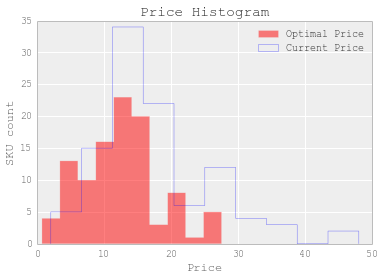

In [45]:

plt.hist(df.optimal_price, histtype='stepfilled',  color='r', alpha=0.5, label='Optimal Price')
plt.hist(df.current_price, histtype='step', color='b', alpha=0.5, label='Current Price')
plt.title("Price Histogram")
plt.xlabel("Price")
plt.ylabel("SKU count")
plt.legend()
plt.show()

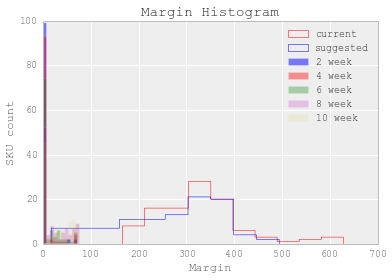

In [51]:
plt.hist(df.current_percentage_achieved_margin , histtype='step', color='r', label='current')
plt.hist(df.suggested_price_percentage_margin, histtype='step', color='b' , label='suggested')
plt.hist(df.price_2_weeks_percentage_margin, histtype='stepfilled',  color='b', alpha=0.5, label='2 week')
plt.hist(df.price_4_weeks_percentage_margin, histtype='stepfilled',  color='r', alpha=0.4, label='4 week')
plt.hist(df.price_6_weeks_percentage_margin, histtype='stepfilled',  color='g', alpha=0.3, label='6 week')
plt.hist(df.price_8_weeks_percentage_margin, histtype='stepfilled',  color='m', alpha=0.2, label='8 week')
plt.hist(df.price_10_weeks_percentage_margin, histtype='stepfilled',  color='y', alpha=0.1, label='10 week')
plt.title("Margin Histogram")
plt.xlabel("Margin")
plt.ylabel("SKU count")
plt.legend()
plt.show()

In [ ]:
    def calculate_clearance_price(self, sku, items_sold_per_week, new_price, ideal_price, sim_items_sold_per_week, cost_price):
        query_string = """SELECT si.ItemID,Code,Price,sip.PriceBandId,pb.Name, bi.confirmedqtyinstock
FROM boohoo.bh_StockItem si
join boohoo.bh_StockItemPrice sip on si.ItemID = sip.ItemID
join boohoo.bh_PriceBand pb on pb.PriceBandID = sip.PriceBandID
join boohoo.bh_binitem bi on si.ItemID = bi.itemid
where pb.Name = 'Offer Price' and split_part(Code, '-', 1) = '{0}'""".format(sku)
        res_df_cl = pd.read_sql_query(query_string, self.engine)
        try:
            price = res_df_cl['price'].loc[0]
        except: 
            price = 0
        clearence_price = price
        week2, week4, week6, week8, week10 = 0, 0, 0, 0, 0
        margin2, margin4, margin6, margin8, margin10 = 0, 0, 0, 0, 0
        tp, tp2, tp4, tp6, tp8, tp10 = 0, 0, 0, 0, 0, 0
        cd2, cd4, cd6, cd8, cd10 = 0, 0, 0, 0, 0


        predicted_throughput = self.sim_items_sold_per_week 
        stock_level = sum(res_df_cl['confirmedqtyinstock'])
        try:
            weeks_of_stock = sum(res_df_cl['confirmedqtyinstock'])/items_sold_per_week
        except: 
            weeks_of_stock = 0
        current_velocity = items_sold_per_week
        current_margin = self.current_price - cost_price
        for weeks in [2,4,6,8,10]:
            if sum(res_df_cl['confirmedqtyinstock']) < (weeks*items_sold_per_week):
                clearence_price = new_price
                tp = predicted_throughput 
            else:
                try:
                    clearence_price = new_price*(items_sold_per_week/(sum(res_df_cl['confirmedqtyinstock'])/weeks))
                    tp = (predicted_throughput - predicted_throughput * (items_sold_per_week/(sum(res_df_cl['confirmedqtyinstock'])/weeks))) + predicted_throughput 
                except: 
                    clearence_price = new_price
                    tp = predicted_throughput 

            if clearence_price < cost_price:
                clearence_price = cost_price
            if new_price < price:
                new_price = price
            if weeks == 2:
                week2= clearence_price
                margin2 = week2 - cost_price
                tp2 = tp
                cd2 = (week2 - self.current_price)*stock_level
            if weeks == 4:
                week4= clearence_price
                margin4 = week4 - cost_price
                tp4 = tp
                cd4 = (week4 - self.current_price)*stock_level
            if weeks == 6:
                week6= clearence_price
                margin6 = week6 - cost_price
                tp6 = tp
                cd6 = (week6 - self.current_price)*stock_level
            if weeks == 8:
                week8= clearence_price
                margin8 = week8 - cost_price
                tp8 = tp
                cd8 = (week8 - self.current_price)*stock_level
            if weeks == 10:
                week10= clearence_price
                margin10 = week10 - cost_price
                tp10 = tp
                cd10 = (week10 - self.current_price)*stock_level

        cost_decision = (new_price - self.current_price)*stock_level
        predicted_margin = new_price - cost_price
        self.spamwriter.writerow([sku, new_price, week2, week4, week6, week8, week10, self.current_price,self.actual_price, weeks_of_stock , current_velocity, current_margin,predicted_throughput,predicted_margin, stock_level, self.name, self.department, margin2, margin4, margin6, margin8, margin10, tp2, tp4, tp6, tp8, tp10, cd2, cd4, cd6, cd8, cd10, cost_decision ])


In [21]:
def boxplotdraw(data,colname, rowname, projname):
    a = data.boxplot(column=colname,by=rowname,sym='k+',vert=False
                            ,widths=0.8,notch=True,bootstrap=1000,figsize=[24,12])
    #a.savefig(str(projname) + 'boxplot' + str(rowname) + '_by_'+str(colname)+ '20150824.png')
    return(a)

gender        0     1
loan_flag            
0          4809  4980
1           100   111
productcount     1     2     3     4     5
loan_flag                                 
0             1922  1974  1983  1950  1960
1               47    38    36    57    33


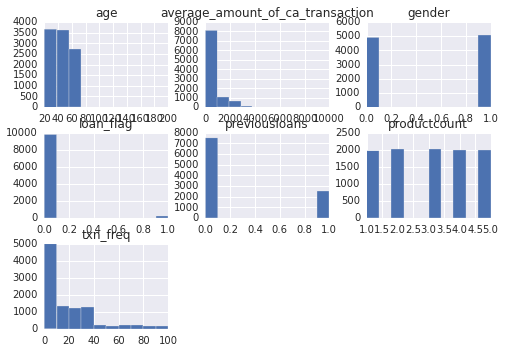

In [11]:
print pd.crosstab(df['loan_flag'], df['gender'], rownames=['loan_flag'])
#print pd.crosstab(df['loan_flag'], df['txn_freq'], rownames=['loan_flag'])
print pd.crosstab(df['loan_flag'], df['productcount'], rownames=['loan_flag'])

df.hist()
pl.show() 

## normalise data for predictions

In [42]:
#Leave this out as it makes it seems to have little effect and makes interepting easier

#def normalise(data):
#    x_normed = data / data.max(axis=0)
#    return(x_normed)
#df.age= normalise(df.age.values)
#df.productcount = normalise(df.productcount.values)
#df.average_amount_of_ca_transaction = normalise(df.average_amount_of_ca_transaction.values)
#df.txn_freq = normalise(df.txn_freq.values)
#print(df.head)

## Decision tree to understand the variables

In [13]:
from sklearn import tree
>>> from sklearn.externals.six import StringIO  
>>> import pydot 

import time
ts = time.time()

train_cols = df1[['age','gender','previousloans','productcount','average_amount_of_ca_transaction','txn_freq']]

y = df1["loan_flag"]
X = train_cols
#five levels, to make it easy to read
clf = tree.DecisionTreeClassifier(min_samples_split=10, random_state=9,max_depth=5)
clf = clf.fit(X, y)


featurenames = ['age','gender','previousloans','productcount','average_amount_of_ca_transaction','txn_freq']
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data,feature_names=featurenames) 
graph = pydot.graph_from_dot_data(dot_data.getvalue())
print(graph)
graph.write_png('decision_tree_'+str(ts) +'_unnormalised_.png')

True

## Single variable analysis

In [111]:
print(dfp['average_amount_of_ca_transaction'].max())
print(dfp['txn_freq'].max())


9470
100


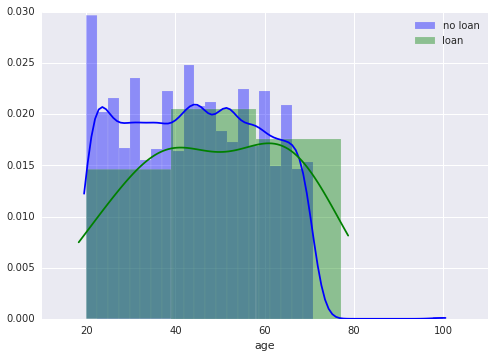

In [138]:
df0 = df1[df["loan_flag"] == 0]
dfloan = df1[df["loan_flag"] == 1]

dfp0 = dfr[dfr["0"] < 0.05]
#dfploan = dfr[dfr["0"] > 0.6]



#sns.distplot(dfploan["age"],color = "blue")
sns.distplot(df0["age"],color = "blue", label = "no loan")
sns.distplot(dfploan["age"],color = "green", label = "loan")
plt.legend()


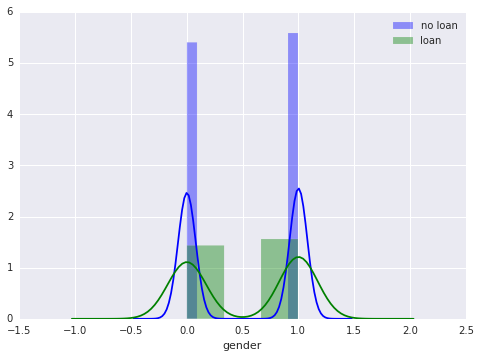

In [140]:
sns.distplot(df0["gender"],color = "blue", label = "no loan")
sns.distplot(dfloan["gender"],color = "green", label = "loan")
plt.legend()

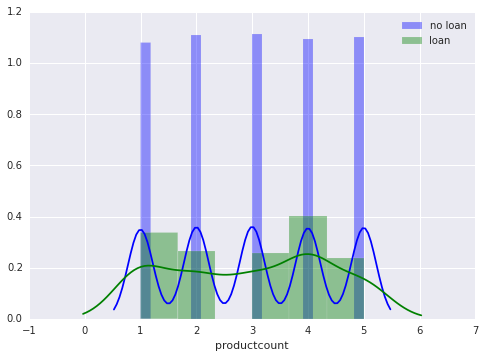

In [149]:
sns.distplot(df0['productcount'],color = "blue", label = "no loan")
sns.distplot(dfloan['productcount'],color = "green", label = "loan")
plt.legend()

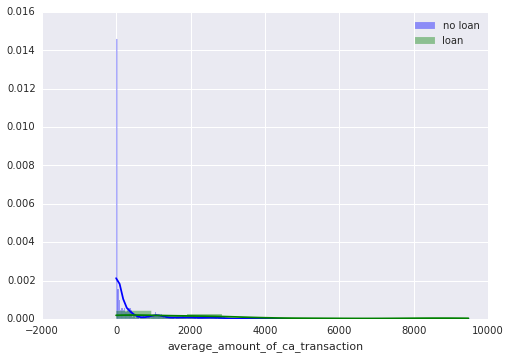

In [148]:
sns.distplot(df0['average_amount_of_ca_transaction'],color = "blue", label = "no loan")
sns.distplot(dfloan['average_amount_of_ca_transaction'],color = "green", label = "loan")
plt.legend()

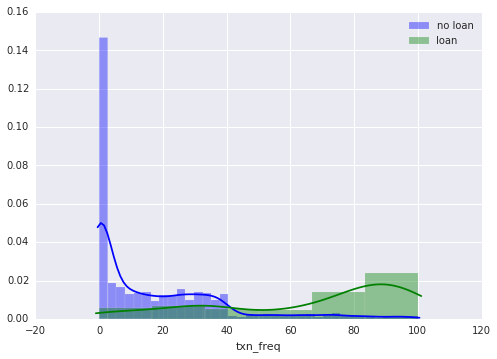

In [147]:
sns.distplot(df0['txn_freq'],color = "blue", label = "no loan")
sns.distplot(dfloan['txn_freq'],color = "green", label = "loan")
plt.legend()

In [58]:
#age = (df1["age"])
o = df1[["loan_flag","age"]]
#print(age)
r = o.corr()
print(r)
#age = (df1["age"])

o = dfr[["0","age"]]
#print(age)
r = o.corr()
print(r)

           loan_flag     age
loan_flag     1.0000  0.0281
age           0.0281  1.0000
          0     age
0    1.0000  0.0253
age  0.0253  1.0000


In [59]:
o = df1[["loan_flag","gender"]]
#print(age)
r = o.corr()
print(r)

o = dfr[["0","gender"]]
#print(age)
r = o.corr()
print(r)

           loan_flag  gender
loan_flag     1.0000  0.0037
gender        0.0037  1.0000
             0  gender
0       1.0000 -0.0055
gender -0.0055  1.0000


In [60]:
o = df1[["loan_flag",'previousloans']]
#print(age)
r = o.corr()
print(r)
o = dfr[["0",'previousloans']]
#print(age)
r = o.corr()
print(r)

               loan_flag  previousloans
loan_flag         1.0000         0.0162
previousloans     0.0162         1.0000
                    0  previousloans
0              1.0000         0.0105
previousloans  0.0105         1.0000


In [61]:
o = df1[["loan_flag",'productcount']]
#print(age)
r = o.corr()
print(r)

o = dfr[["0",'productcount']]
#print(age)
r = o.corr()
print(r)

              loan_flag  productcount
loan_flag        1.0000       -0.0049
productcount    -0.0049        1.0000
                   0  productcount
0             1.0000       -0.0572
productcount -0.0572        1.0000


In [62]:
o = df1[["loan_flag",'average_amount_of_ca_transaction']]
#print(age)
r = o.corr()
print(r)

o = dfr[["0",'average_amount_of_ca_transaction']]
#print(age)
r = o.corr()
print(r)

                                  loan_flag  average_amount_of_ca_transaction
loan_flag                            1.0000                            0.3248
average_amount_of_ca_transaction     0.3248                            1.0000
                                       0  average_amount_of_ca_transaction
0                                 1.0000                            0.2671
average_amount_of_ca_transaction  0.2671                            1.0000


In [63]:
o = df1[["loan_flag",'txn_freq']]
#print(age)
r = o.corr()
print(r)

o = dfr[["0",'txn_freq']]
#print(age)
r = o.corr()
print(r)

           loan_flag  txn_freq
loan_flag     1.0000    0.3059
txn_freq      0.3059    1.0000
               0  txn_freq
0         1.0000    0.6884
txn_freq  0.6884    1.0000


In [112]:
pname = 'quintile_results_v2.csv'
results = getcsv(pname,Idirname,textfieldname)
dfr = results[['age','gender','previousloans','productcount','average_amount_of_ca_transaction','txn_freq','0']]
features = ['age','gender','previousloans','productcount','average_amount_of_ca_transaction','txn_freq']


fld ='age'
dft = outliers(dfp,10,fld)

(2000, 7)


## lift plotting

In [108]:
from math import log

def sortTestSetByProbability(y_test, y_probs):
    sortedIndexList = sorted(range(len(y_probs)), key=lambda k: y_probs[k], reverse=True)
    return [(y_probs[i], y_test[i], i) for i in sortedIndexList]

def calculateLift(sortedProbsAndTrueLabels, nrPercentiles=10, posLabel=1):
    ''' Input is a list of tuples containing (prob, true label), sorted in descending order per prob
        Output is a a list of nrPercentiles tuples containing, for each percentile:
        (percentOfTargetPopulationInThisPercentile,
         percentOfPositivePopulationInThisPercentile,
         cumulativeLift,
         localLift
         )
    '''
    numberOfPositiveInstances = len([x for x in sortedProbsAndTrueLabels if x[1] == posLabel])
    percentileSplitOfInstances = [np_array.tolist() for np_array in np.array_split(np.array([x[1] for x in sortedProbsAndTrueLabels]), nrPercentiles)]
#    print "len(percentileSplitOfInstances) = ", len(percentileSplitOfInstances)
#    print "percentileSplitOfInstances[0:2] = ", percentileSplitOfInstances[0:2]
    result = [(0.0,0.0,0.0,0.0)]
    cumulativePercentage = 0.0
    cumulativeLift = 0
    localLift = 0
    for c in range(len(percentileSplitOfInstances)):
        percentile = percentileSplitOfInstances[c]
        nrPositivesInPercentile = len([x for x in percentile if x == posLabel])
        p = float(c+1)/float(nrPercentiles)
        cumulativePercentage += float(nrPositivesInPercentile)/float(numberOfPositiveInstances)
        cumulativeLift = cumulativePercentage/p
        localLift = (float(nrPositivesInPercentile)/float(numberOfPositiveInstances))/(1.0/float(nrPercentiles))
        result.append((p,cumulativePercentage,cumulativeLift, localLift))
    return result

def plotLiftCurve(numberOfPercentiles=10, figSize=5):
    # Define some CSS to control our custom labels
    css = """
table {
  border-collapse: collapse;
}
th {
  color: #ffffff;
  background-color: #000000;
}
td {
  padding: 2px;
  background-color: #cccccc;
}
table, th, td {
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""
liftCurveFigure, ax = plt.subplots(figsize=7)
ax.grid(True, alpha=0.3)
ax.set_autoscaley_on(False)
ax.set_ylim([0,100])
for modelName, probs in finalPredictions.iteritems():
    modelNameShort = re.split("\s+", modelName)[0]
    y_probs = [x[1] for x in finalPredictions[modelName]['test']]
    sortedProbsAndTrueLabels = sortTestSetByProbability(y_test,y_probs)
    lifts = calculateLift(sortedProbsAndTrueLabels, nrPercentiles=numberOfPercentiles, posLabel=1)
#        print modelName, lifts
    xPerc = [x[0]*100 for x in lifts]
    yPerc = [x[1]*100 for x in lifts]
    ax.set_title("Lift curve for prediction of successful term deposit sale", y=1.06, fontsize=14 + log(figSize))
ax.set_xlabel("Percentage of test instances (decreasing by probability)", labelpad=15 + log(figSize), fontsize=12 + log(figSize))
ax.set_ylabel("Percentage of positive instances targeted", labelpad=15 + log(figSize), fontsize=12 + log(figSize))
plt.legend(loc=4)
plt.show()
    

TypeError: from_bounds() argument after * must be a sequence, not int

## Logistic regression classifier

In [51]:
#normalising to Log regression is very important
def normalise(data):
    x_normed = data / data.max(axis=0)
    return(x_normed)
df.age= normalise(df.age.values)
df.productcount = normalise(df.productcount.values)
df.average_amount_of_ca_transaction = normalise(df.average_amount_of_ca_transaction.values)
df.txn_freq = normalise(df.txn_freq.values)
#print(df.head)

train_cols = df[['age','gender','previousloans','productcount','average_amount_of_ca_transaction','txn_freq']]

y = df["loan_flag"]
X = train_cols
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set - 98% ....REALlY?
model.score(X, y)

0.98350000000000004

In [11]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

#product count and gender seem to have a negative influence on becoming a loan person

#value of transactions and how often you tranaction seems to have a heavier influence, 
#age seems to be corelated it does not appear to be a determining factor when compared with customer value and behaviour
#previous loans does not appear that significant

,0,1
0,age,[1.46769490347]
1,gender,[-0.103960225706]
2,previousloans,[0.169576935985]
3,productcount,[-0.492904210861]
4,average_amount_of_ca_transaction,[8.605826748]
5,txn_freq,[5.91950122815]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)
predicted = model2.predict(X_test)

#pd.DataFrame(predicted).to_csv('log_results.csv',encoding='utf-8', index=False)
# generate class probabilities
probs = model2.predict_proba(X_test)
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
#print scores
print scores.mean()

0.982
0.977863975888
[[2931    4]
 [  50   15]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2935
          1       0.79      0.23      0.36        65

avg / total       0.98      0.98      0.98      3000

0.9831


In [54]:
probs = model2.predict_proba(X)
dfp = df.join(pd.DataFrame(probs))
print(dfp.head)
dfp.columns = ['age','gender','previousloans','productcount','average_amount_of_ca_transaction','txn_freq','loan_flag','no_loan', 'loan']
#print(dfp.head)
dfp.to_csv('log_probs_results.csv',encoding='utf-8', index=False)


<bound method DataFrame.head of         age  gender  previousloans  productcount  average_amount_of_ca_transaction  txn_freq  loan_flag       0       1
0     0.180       1              0           0.8                            0.0061      0.00          0  0.9988  0.0012
1     0.215       1              0           0.8                            0.2812      0.17          0  0.9733  0.0267
2     0.160       0              0           0.4                            0.0049      0.25          0  0.9933  0.0067
3     0.260       1              0           0.4                            0.0000      0.13          0  0.9969  0.0031
4     0.315       0              0           0.2                            0.0133      0.39          0  0.9807  0.0193
5     0.165       0              0           0.4                            0.0357      0.39          0  0.9820  0.0180
6     0.125       0              0           0.2                            0.0000      0.16          0  0.9956  0.0044
7     0.

## run the predictor

In [48]:
raw = getcsv(pname,Idirname,textfieldname)
dfx = raw[['age','gender','previousloans','productcount','average_amount_of_ca_transaction','txn_freq']]
features = ['age','gender','previousloans','productcount','average_amount_of_ca_transaction','txn_freq']


fld ='age'
dfx = outliers(dfx,10,fld)
dfx.age= normalise(dfx.age.values)
dfx.productcount = normalise(dfx.productcount.values)
dfx.average_amount_of_ca_transaction = normalise(dfx.average_amount_of_ca_transaction.values)
dfx.txn_freq = normalise(dfx.txn_freq.values)

X = dfx
#print(dfp.head)
#y = df["loan_flag"]
#X = train_cols
probs = model2.predict_proba(X)
dfx = dfx.join(pd.DataFrame(probs))

dfx.columns = ['age','gender','previousloans','productcount','average_amount_of_ca_transaction','txn_freq','no_loan', 'loan']
#print(dfp.head)
dfx.to_csv('test_probs_results.csv',encoding='utf-8', index=False)
print(dfx.head)

(2000, 7)
<bound method DataFrame.head of          age  gender  previousloans  productcount  average_amount_of_ca_transaction  txn_freq  no_loan    loan
0     0.7375       1              0           0.8                            0.0023      0.00   0.9983  0.0017
1     0.3375       1              0           0.8                            0.0012      0.17   0.9969  0.0031
2     0.7250       0              0           0.4                            0.0010      0.25   0.9900  0.0100
3     0.5625       1              0           0.4                            0.0036      0.13   0.9960  0.0040
4     0.2625       0              0           0.2                            0.0040      0.39   0.9827  0.0173
5     0.4750       0              0           0.4                            0.0052      0.39   0.9821  0.0179
6     0.5375       0              0           0.2                            0.0033      0.16   0.9937  0.0063
7     0.5625       1              1           0.8                     

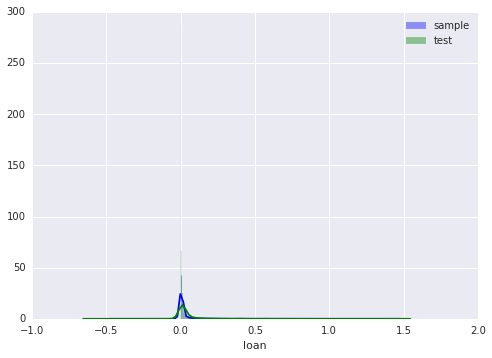

In [56]:
sns.distplot(dfp['loan'],color = "blue", label = "sample")
sns.distplot(dfx['loan'],color = "green", label = "test")
plt.legend()

In [94]:
#pd.DataFrame(probs).to_csv('log_probs_results_2.csv',encoding='utf-8', index=False)
l = np.hstack((probs[:,:1]))
#l = np.hstack((probs))

#l = probs.flatten
print(l)
quintile = pd.qcut((l), 5)
                   #, labels=["`Very High Likelihood","High Likelihood","Medium Likelihood","Low Likelihood","Very Low Likelihood"])

print(quintile)

#segement = quintile
#print(segement)
#t = pd.DataFrame(t)
t = pd.DataFrame(dft).join(pd.DataFrame(l))
#t = t.join(quintile)
quintile.to_csv('quintile_segment.csv',encoding='utf-8', index=False)
t.to_csv('quintile_results.csv',encoding='utf-8', index=False)

(2000, 7)
[ 0.99921677  0.99808615  0.99534956 ...,  0.99832322  0.97964488
  0.99752848]
 (0.998, 0.999]
 (0.998, 0.999]
 (0.992, 0.996]
 (0.996, 0.998]
 (0.979, 0.992]
 (0.979, 0.992]
 (0.996, 0.998]
 (0.998, 0.999]
 (0.998, 0.999]
 (0.998, 0.999]
 (0.998, 0.999]
 (0.998, 0.999]
 (0.998, 0.999]
...
 (0.996, 0.998]
 [0.238, 0.979]
 (0.996, 0.998]
 (0.992, 0.996]
 (0.979, 0.992]
 (0.992, 0.996]
 [0.238, 0.979]
 [0.238, 0.979]
 (0.996, 0.998]
 (0.979, 0.992]
 (0.998, 0.999]
 (0.979, 0.992]
 (0.996, 0.998]
Levels (5): Index(['[0.238, 0.979]', '(0.979, 0.992]', '(0.992, 0.996]',
                   '(0.996, 0.998]', '(0.998, 0.999]'], dtype=object)
Length: 2000


AttributeError: 'Categorical' object has no attribute 'to_csv'

In [317]:
e = clf.predict_proba(X)
g = pd.DataFrame(e[:,0])

g.to_csv('percentile_results2.csv',encoding='utf-8', index=False)

In [276]:
s  = 0

#t = [x[0] for x in ]

print(pd.DataFrame(probs))


           0       1
0     0.9989  0.0011
1     0.9974  0.0026
2     0.9929  0.0071
3     0.9973  0.0027
4     0.9842  0.0158
5     0.9850  0.0150
6     0.9953  0.0047
7     0.9969  0.0031
8     0.9980  0.0020
9     0.9976  0.0024
10    0.9985  0.0015
11    0.9982  0.0018
12    0.9985  0.0015
13    0.9955  0.0045
14    0.9986  0.0014
15    0.9982  0.0018
16    0.9976  0.0024
17    0.9988  0.0012
18    0.9982  0.0018
19    0.9850  0.0150
20    0.9958  0.0042
21    0.9961  0.0039
22    0.9609  0.0391
23    0.9976  0.0024
24    0.9869  0.0131
25    0.9800  0.0200
26    0.9954  0.0046
27    0.9942  0.0058
28    0.9935  0.0065
29    0.9959  0.0041
30    0.9982  0.0018
31    0.9933  0.0067
32    0.7641  0.2359
33    0.9985  0.0015
34    0.9989  0.0011
35    0.9977  0.0023
36    0.9982  0.0018
37    0.9975  0.0025
38    0.9979  0.0021
39    0.9925  0.0075
40    0.9936  0.0064
41    0.9937  0.0063
42    0.9986  0.0014
43    0.9983  0.0017
44    0.9934  0.0066
45    0.9983  0.0017
46    0.8567 

In [233]:
from sklearn.cross_validation import KFold

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score


def accuracy(y_true,y_pred):
    # NumPy interprets True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print "Logistic Regression:"
print "%.3f" % accuracy(y, run_cv(X,y,LR))
print "Gradient Boosting Classifier"
print "%.3f" % accuracy(y, run_cv(X,y,GBC))
print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X,y,SVC))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X,y,RF))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X,y,KNN))

Logistic Regression:
0.983
Gradient Boosting Classifier
0.981
Support vector machines:
0.979
Random forest:
0.981
K-nearest-neighbors:
0.979


[[9744   45]
 [ 142   69]]


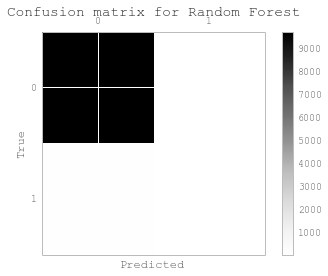

In [235]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
  
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
  
]

# Pyplot code not included to reduce clutter
#from churn_display import draw_confusion_matrices

draw_confusion_matrices(confusion_matrices,class_names)

Support vector machines:


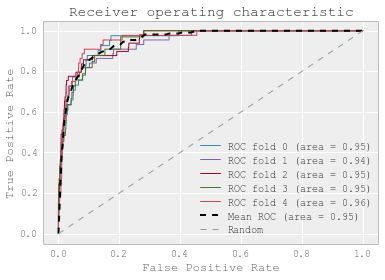

Random forests:


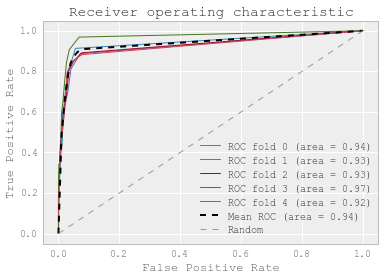

K-nearest-neighbors:


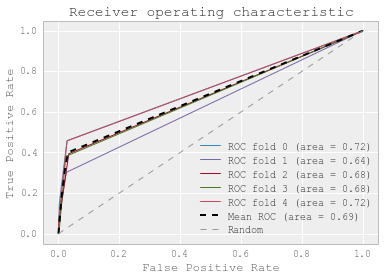

Gradient Boosting Classifier:


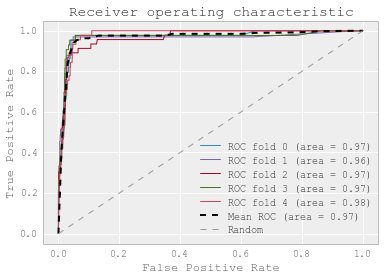

In [236]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
      

print "Support vector machines:"
plot_roc(X,y,SVC,probability=True)

print "Random forests:"
plot_roc(X,y,RF,n_estimators=18)

print "K-nearest-neighbors:"
plot_roc(X,y,KNN)

print "Gradient Boosting Classifier:"
plot_roc(X,y,GBC)

In [217]:
def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

In [259]:
import warnings
warnings.filterwarnings('ignore')

# Use 5 estimators so predictions are all multiples of 0.2
pred_prob = run_prob_cv(X, y, RF, n_estimators=5)
pred_loan = pred_prob[:,1]
is_loan = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_loan)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_loan[pred_loan == prob])
    true_prob = pd.Series(true_prob)

#tabulate the results
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,9480,0.0059
1,0.2,257,0.1790
2,0.4,112,0.2946
3,0.6,76,0.3684
4,0.8,47,0.5532
5,1.0,23,0.8696


In [260]:
t = pd.DataFrame(pred_loan)
t = pd.DataFrame(df).join(pd.DataFrame(t))

t.to_csv('known_results.csv',encoding='utf-8', index=False)

## Run the model

## k nearest neighbour to classify

Neighbors: 1, Accuracy: 1.000000
Neighbors: 2, Accuracy: 0.985011
Neighbors: 3, Accuracy: 0.985153
Neighbors: 4, Accuracy: 0.983440
Neighbors: 5, Accuracy: 0.984154


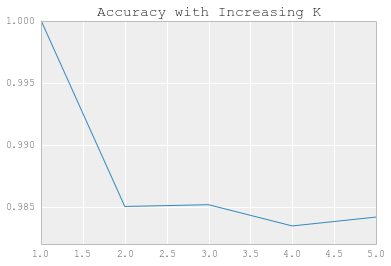

In [63]:
test_idx = np.random.uniform(0, 1, len(df)) <= 0.3
train = df[test_idx==True]
test = df[test_idx==False]


features = ['age','gender','previousloans','productcount','average_amount_of_ca_transaction','txn_freq']
y = df["loan_flag"]
X = train_cols
results = []
for n in range(1, 6, 1):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X, y)
    preds = clf.predict(test[features])
    accuracy = np.where(preds==test['loan_flag'], 1, 0).sum() / float(len(test))
    print "Neighbors: %d, Accuracy: %3f" % (n, accuracy)

    results.append([n, accuracy])

results = pd.DataFrame(results, columns=["n", "accuracy"])

pl.plot(results.n, results.accuracy)
pl.title("Accuracy with Increasing K")
pl.show()

## Kmeans

[[ 0.51428571  1.          0.         ...,  0.0061246   0.          0.        ]
 [ 0.61428571  1.          0.         ...,  0.2812038   0.17        0.        ]
 [ 0.45714286  0.          0.         ...,  0.00485744  0.25        0.        ]
 ..., 
 [ 0.61428571  1.          0.         ...,  0.          0.          0.        ]
 [ 0.45714286  0.          0.         ...,  0.          0.37        0.        ]
 [ 0.74285714  1.          0.         ...,  0.          0.06        0.        ]]


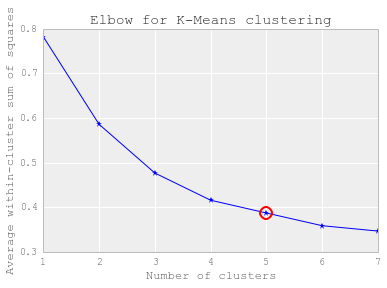

In [89]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
##### cluster data into K=1..10 clusters #####
#K, KM, centroids,D_k,cIdx,dist,avgWithinSS = kmeans.run_kmeans(X,10)
nparray = np.array(df)
#print(nparray)
K = range(1,8)

# scipy.cluster.vq.kmeans
KM = [kmeans(nparray,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(nparray, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/nparray.shape[0] for d in dist]  

kIdx = 4
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

## Standard clustering plot 

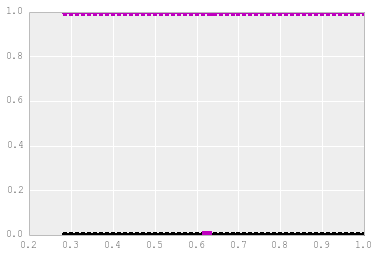

In [70]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq

# now with K = 3 (3 clusters)
centroids,_ = kmeans(nparray,5)
idx,_ = vq(nparray,centroids)

plot(nparray[idx==0,0],nparray[idx==0,1],'ob',
     nparray[idx==1,0],nparray[idx==1,1],'ok',
     nparray[idx==2,0],nparray[idx==2,1],'og',
     nparray[idx==2,0],nparray[idx==2,1],'oc',
     nparray[idx==2,0],nparray[idx==2,1],'om',
     ) # third cluster points
plot(centroids[:,0],centroids[:,1],'sm',markersize=8)
show()

In [71]:
from sklearn.cross_validation import train_test_split
array_fit, array_fit1 = train_test_split(nparray, train_size=.01)


In [73]:
%pylab inline

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

hpc = PCA(n_components=2).fit_transform(array_fit)
#print hpc

Populating the interactive namespace from numpy and matplotlib


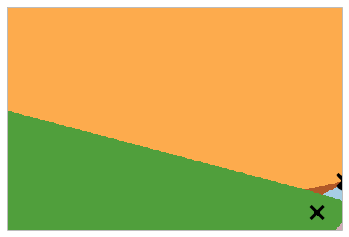

In [74]:
k_means = KMeans()
k_means.fit(hpc)

x_min, x_max = hpc[:, 0].min() - 5, hpc[:, 0].max() - 1
y_min, y_max = hpc[:, 1].min(), hpc[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = k_means.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired,
          aspect='auto', origin='lower')

plt.plot(hpc[:, 0], hpc[:, 1], 'k.', markersize=8)
centroids = k_means.cluster_centers_
inert = k_means.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1],
           marker='x', s=169, linewidths=3,
           color='k', zorder=8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

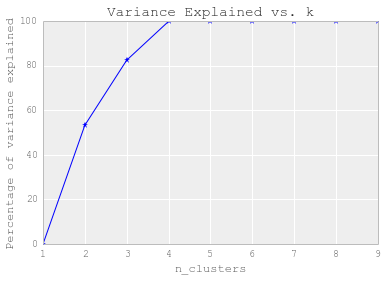

In [76]:
import numpy as np
from scipy.spatial.distance import cdist, pdist
from matplotlib import pyplot as plt

# Determine your k range
k_range = range(1,10)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(hpc) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(hpc, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(hpc)**2)/hpc.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')

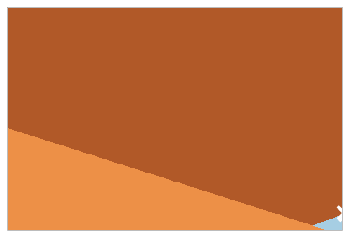

In [77]:
# run 8/random, 7/kmeans++ for silhouette
k_means = KMeans(n_clusters=8)
k_means.fit(hpc)

x_min, x_max = hpc[:, 0].min() - 5, hpc[:, 0].max() - 1
y_min, y_max = hpc[:, 1].min() + 1, hpc[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = k_means.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired,
          aspect='auto', origin='lower')

plt.plot(hpc[:, 0], hpc[:, 1], 'k.', markersize=4)
# Plot the centroids as a white X
centroids = k_means.cluster_centers_
inert = k_means.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1],
           marker='x', s=169, linewidths=3,
           color='w', zorder=8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [78]:
##### cluster data into K=1..10 clusters #####
#K, KM, centroids,D_k,cIdx,dist,avgWithinSS = kmeans.run_kmeans(X,10)

K = range(1,8)

# scipy.cluster.vq.kmeans
KM = [kmeans(nparray,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(nparray, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/nparray.shape[0] for d in dist]  

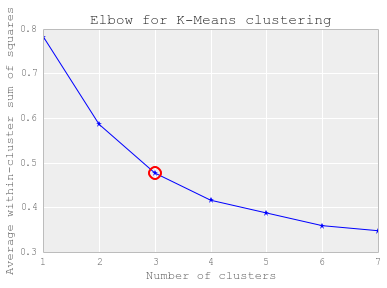

In [79]:
kIdx = 2
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

In [22]:
from sklearn.cluster import KMeans
km = KMeans(3, init='k-means++') # initialize
km.fit(Y)
c = km.predict(Y) # classify into three clusters

In [24]:
# see the code in helper library kmeans.py
# it wraps a number of variables and maps integers to categoriy labels
# this wrapper makes it easy to interact with this code and try other variables
# as we see below in the next plot
import KMeans as mykm
(pl0,pl1,pl2) = mykm.plot_clusters(X,c,3,2) # column 3 GDP, vs column 2 infant mortality. Note indexing is 0 based

ImportError: No module named KMeans

### KDE plot

In [97]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
#from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


#these only work in Python 3.x
def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    





#kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
#kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

kde_funcs = [ kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = [ 'Statsmodels-M', 'Scipy', 'Scikit-learn']

print "Package Versions:"
import sklearn; print "  scikit-learn:", sklearn.__version__
import scipy; print "  scipy:", scipy.__version__
import statsmodels; print "  statsmodels:", statsmodels.__version__

Package Versions:
  scikit-learn: 0.14.1
  scipy: 0.15.1
  statsmodels: 0.5.0


In [ ]:
from scipy.stats.distributions import norm

# The grid we'll use for plotting
#x_grid = np.linspace(-4.5, 3.5, 1000)
x_grid = np.linspace(0, 5000, 10000)

# Draw points from a bimodal distribution in 1D
#np.random.seed(0)
#x = np.concatenate([norm(-1, 1.).rvs(400),
#                    norm(1, 0.3).rvs(100)])
print(df2.maxpost.shape)
u= df2.maxpost
#print(u.shape)

x = u[~np.isnan(u)]
x = np.array(x)

pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

### KDE Bandwidth

In [ ]:
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': x_grid},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print grid.best_params_
bandw = grid.best_params_

### Plot KDE with bandwidth

In [ ]:
# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 3, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(3):
    pdf = kde_funcs[i](x, x_grid, bandwidth=bandw)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    #ax[i].set_xlim(0, 5)
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution</font>")
